### Task 1 - M1

In [1]:
import pickle
import numpy as np
import pandas as pd

# Load these embeddings from the pickle files
train_embeddings_file = "train_embeddings.pkl"
val_embeddings_file = "val_embeddings.pkl"

train_embeddings_loaded = pickle.load(open(train_embeddings_file, "rb"))
val_embeddings_loaded = pickle.load(open(val_embeddings_file, "rb"))

In [2]:
# Load the labels from the pickle files
task1_train_labels = "task1_labels_train.pkl"
task1_val_labels = "task1_labels_dev.pkl"

task1_train_labels_loaded = pickle.load(open(task1_train_labels, "rb"))
task1_val_labels_loaded = pickle.load(open(task1_val_labels, "rb"))

In [3]:
# # For each key, pad the embeddings and labels to the maximum length of 24
# # Pad the embeddings with zeros and the labels with -1
# max_length = 24

# for key in train_embeddings_loaded.keys():
#     if len(train_embeddings_loaded[key]) < max_length:
#         train_embeddings_loaded[key] = np.concatenate((train_embeddings_loaded[key], np.zeros((max_length - len(train_embeddings_loaded[key]), 384))))
#         task1_train_labels_loaded[key] = np.concatenate((task1_train_labels_loaded[key], np.full((max_length - len(task1_train_labels_loaded[key])), -1)))

# for key in val_embeddings_loaded.keys():
#     if len(val_embeddings_loaded[key]) < max_length:
#         val_embeddings_loaded[key] = np.concatenate((val_embeddings_loaded[key], np.zeros((max_length - len(val_embeddings_loaded[key]), 384))))
#         task1_val_labels_loaded[key] = np.concatenate((task1_val_labels_loaded[key], np.full((max_length - len(task1_val_labels_loaded[key])), -1)))

In [4]:
# Get all unique labels
unique_labels = set()
for key in task1_train_labels_loaded.keys():
    unique_labels.update(task1_train_labels_loaded[key])

for key in task1_val_labels_loaded.keys():
    unique_labels.update(task1_val_labels_loaded[key])

print(unique_labels)

{'joy', 'anger', 'sadness', 'disgust', 'fear', 'neutral', 'surprise'}


In [5]:
# Encode the labels by a fixed mapping
mapping = {
    "-1": 0,
    "sadness": 1,
    "joy": 2,
    "fear": 3,
    "anger": 4,
    "surprise": 5,
    "disgust": 6,
    "neutral": 7
}

# Convert labels to indices and store in lists using list comprehension
train_labels = [np.array([mapping[str(label)] for label in task1_train_labels_loaded[key]]) for key in task1_train_labels_loaded.keys()]
val_labels = [np.array([mapping[str(label)] for label in task1_val_labels_loaded[key]]) for key in task1_val_labels_loaded.keys()]

In [6]:
# Convert embeddings to lists
train_embeddings = [train_embeddings_loaded[key] for key in train_embeddings_loaded.keys()]
val_embeddings = [val_embeddings_loaded[key] for key in val_embeddings_loaded.keys()]

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings  # List of embedding matrices
        self.labels = labels  # List of label arrays

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx]), torch.tensor(self.labels[idx], dtype=torch.long)
    
def collate_fn(batch):
    embeddings, labels = zip(*batch)
    embeddings_pad = torch.nn.utils.rnn.pad_sequence(embeddings, batch_first=True, padding_value=0)
    labels_pad = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-1)  # Use -1 for padding
    return embeddings_pad, labels_pad

In [8]:
# Make train dataset and dataloader
train_dataset = EmotionDataset(train_embeddings, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Make val dataset and dataloader
val_dataset = EmotionDataset(val_embeddings, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [9]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc(output)
        return output

In [10]:
# Initialize the model
INPUT_SIZE = 384 # Dimension of the input embeddings
HIDDEN_SIZE = 128 # Dimension of the hidden state
OUTPUT_SIZE = 8 # Number of classes

model = RNNModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

In [11]:
# Define the loss function and optimizer
from torch.optim import Adam

loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = Adam(model.parameters(), lr=0.001)

In [12]:
# Compute F1 metrics
from sklearn.metrics import f1_score

# Predictions and labels should be flattened arrays
def compute_metrics(predictions, labels):
    mask = labels != -1  # Ignore padded labels
    masked_labels = labels[mask]
    masked_predictions = predictions[mask]
    weighted_f1 = f1_score(masked_labels, masked_predictions, average='weighted')
    macro_f1 = f1_score(masked_labels, masked_predictions, average='macro')
    return weighted_f1, macro_f1

In [13]:
# Train the model
num_epochs = 15

train_f1s = []
val_f1s = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0
    train_predictions = []
    train_labels = []

    for embeddings, labels in train_dataloader:
        optimizer.zero_grad()
        output = model(embeddings)
        
        # Flatten the output and labels
        output = output.view(-1, output.shape[-1]) # (batch_size * max_length, num_classes)
        labels = labels.view(-1)

        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Get the predictions
        predictions = output.argmax(dim=-1)

        train_predictions.append(predictions.detach().cpu().numpy())
        train_labels.append(labels.detach().cpu().numpy())

    train_predictions = np.concatenate(train_predictions)
    train_labels = np.concatenate(train_labels)
    train_loss /= len(train_dataloader)

    weighted_f1, macro_f1 = compute_metrics(train_predictions, train_labels)

    train_f1s.append(weighted_f1)
    train_losses.append(train_loss)

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for embeddings, labels in val_dataloader:
            output = model(embeddings)
            
            # Flatten the output and labels
            output = output.view(-1, output.shape[-1])
            labels = labels.view(-1)

            loss = loss_fn(output, labels)
            val_loss += loss.item()

            # Get the predictions
            predictions = output.argmax(dim=-1)

            val_predictions.append(predictions.detach().cpu().numpy())
            val_labels.append(labels.detach().cpu().numpy())

    val_predictions = np.concatenate(val_predictions)
    val_labels = np.concatenate(val_labels)

    val_loss /= len(val_dataloader)

    weighted_f1_val, macro_f1_val = compute_metrics(val_predictions, val_labels)

    val_f1s.append(weighted_f1_val)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Weighted F1: {weighted_f1:.4f}, Train Macro F1: {macro_f1:.4f}, Val Loss: {val_loss:.4f}, Val Weighted F1: {weighted_f1_val:.4f}, Val Macro F1: {macro_f1_val:.4f}")
            

Epoch 1/15, Train Loss: 1.5131, Train Weighted F1: 0.3582, Train Macro F1: 0.1666, Val Loss: 1.3250, Val Weighted F1: 0.4814, Val Macro F1: 0.2693
Epoch 2/15, Train Loss: 1.2291, Train Weighted F1: 0.5261, Train Macro F1: 0.3110, Val Loss: 1.1732, Val Weighted F1: 0.5413, Val Macro F1: 0.3323
Epoch 3/15, Train Loss: 1.0933, Train Weighted F1: 0.5850, Train Macro F1: 0.3757, Val Loss: 1.0387, Val Weighted F1: 0.6105, Val Macro F1: 0.4041
Epoch 4/15, Train Loss: 0.9727, Train Weighted F1: 0.6425, Train Macro F1: 0.4564, Val Loss: 0.9108, Val Weighted F1: 0.6613, Val Macro F1: 0.4968
Epoch 5/15, Train Loss: 0.8644, Train Weighted F1: 0.6961, Train Macro F1: 0.5538, Val Loss: 0.8383, Val Weighted F1: 0.7172, Val Macro F1: 0.6054
Epoch 6/15, Train Loss: 0.7708, Train Weighted F1: 0.7448, Train Macro F1: 0.6374, Val Loss: 0.7511, Val Weighted F1: 0.7482, Val Macro F1: 0.6344
Epoch 7/15, Train Loss: 0.6824, Train Weighted F1: 0.7800, Train Macro F1: 0.6958, Val Loss: 0.6912, Val Weighted F1: 

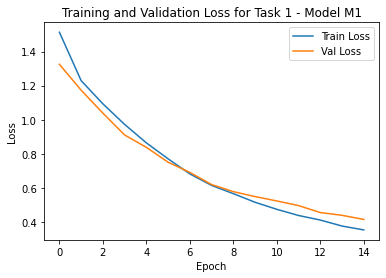

In [14]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for Task 1 - Model M1")

plt.legend()
plt.show()

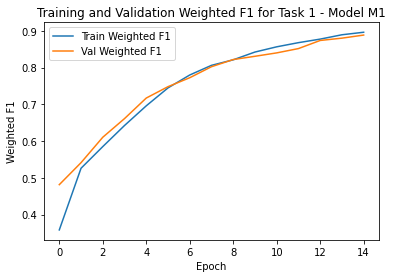

In [15]:
# Plot the training and validation F1 scores
plt.plot(train_f1s, label="Train Weighted F1")
plt.plot(val_f1s, label="Val Weighted F1")

plt.xlabel("Epoch")
plt.ylabel("Weighted F1")
plt.title("Training and Validation Weighted F1 for Task 1 - Model M1")
plt.legend()
plt.show()

In [16]:
# Save the model
torch.save(model.state_dict(), "M1_Task1.pth")

- Inference on a sample from validation set

In [17]:
# Run inference on the a sample from validation set
model.eval()

sample_idx = 218
sample_embeddings, sample_labels = val_dataset[sample_idx]

sample_embeddings = sample_embeddings.unsqueeze(0)  # Add batch dimension
sample_labels = sample_labels.unsqueeze(0)

with torch.no_grad():
    output = model(sample_embeddings)
    predictions = output.argmax(dim=-1)

    print("Predictions:", predictions[0])
    print("Labels:", sample_labels[0])

    # Calculate the F1 score
    weighted_f1, macro_f1 = compute_metrics(predictions.cpu().numpy(), sample_labels.cpu().numpy())
    print("Weighted F1:", weighted_f1)
    print("Macro F1:", macro_f1)

Predictions: tensor([7, 2, 2, 2, 7, 7, 1, 6, 2, 7, 7, 7, 7, 7, 4, 5, 7, 2, 4, 4])
Labels: tensor([7, 6, 4, 2, 2, 1, 1, 1, 2, 7, 7, 7, 7, 7, 4, 3, 3, 3, 5, 4])
Weighted F1: 0.49000000000000005
Macro F1: 0.3523809523809524


In [18]:
# Test on sample from validation set
episode_id = "utterance_2314"
sample_embeddings = val_embeddings_loaded[episode_id]
sample_labels = task1_val_labels_loaded[episode_id]

sample_embeddings = torch.tensor(sample_embeddings).unsqueeze(0)  # Add batch dimension

# encode the labels
sample_labels = np.array([mapping[str(label)] for label in sample_labels])

sample_labels = torch.tensor(sample_labels).unsqueeze(0)

with torch.no_grad():
    output = model(sample_embeddings)
    predictions = output.argmax(dim=-1)

    print("Predictions:", predictions[0])
    print("Labels:", sample_labels[0])

    # Calculate the F1 score
    weighted_f1, macro_f1 = compute_metrics(predictions.cpu().numpy(), sample_labels.cpu().numpy())
    print("Weighted F1:", weighted_f1)
    print("Macro F1:", macro_f1)



Predictions: tensor([7, 2, 2, 7, 7, 7, 6, 7, 2, 7, 2])
Labels: tensor([7, 2, 2, 7, 7, 7, 6, 7, 2, 7, 2])
Weighted F1: 1.0
Macro F1: 1.0
